In [8]:
import math
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from PIL import Image
from sklearn.inspection import DecisionBoundaryDisplay

from counterfactuals.datasets import BlobsDataset, DigitsDataset, MoonsDataset
from counterfactuals.discriminative_models import LogisticRegression, MultinomialLogisticRegression, NODE
from counterfactuals.generative_models import MaskedAutoregressiveFlow


def plot_generative_model_distribution(ax, model, prob_threshold, num_classes):
    xline = torch.linspace(-0.25, 1.25, 200)
    yline = torch.linspace(-0.25, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    for i in range(num_classes):
        with torch.no_grad():
            zgrid = model(xyinput, i * torch.ones(40000, 1)).exp().reshape(200, 200)
            zgrid = zgrid.numpy()
            _ = ax.contour(
                xgrid.numpy(),
                ygrid.numpy(),
                zgrid,
                levels=10,
                cmap="Greys",
                linewidths=0.4,
                antialiased=True,
            )

        if prob_threshold is not None:
            prob_threshold_exp = np.exp(prob_threshold)
            _ = ax.contourf(
                xgrid.numpy(), ygrid.numpy(), zgrid,
                levels=[prob_threshold_exp, prob_threshold_exp * 10.00],
                alpha=0.1,
                colors='#DC143C'
            )  # 10.00 is an arbitrary huge value to colour the whole distribution.

    return ax


def plot_classifier_decision_region(ax, model):
    xline = torch.linspace(-0.25, 1.25, 200)
    yline = torch.linspace(-0.25, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    y_hat = model.predict(xyinput)
    y_hat = y_hat.reshape(200, 200)

    display = DecisionBoundaryDisplay(xx0=xgrid, xx1=ygrid, response=y_hat)
    ax = display.plot(plot_method="contour", ax=ax, alpha=0.5).ax_
    return ax


def plot_counterfactuals(ax, counterfactuals):
    ax.scatter(counterfactuals[:, 0], counterfactuals[:, 1], c="orange", s=50, alpha=0.8)
    return ax


def plot_observations(ax, observations, targets):
    ax.scatter(observations[:, 0], observations[:, 1], c=targets, cmap=matplotlib.colormaps["tab10"], s=50, alpha=0.8)
    return ax


def plot_arrows(ax, observations, counterfactuals):
    for i in range(len(X_test)):
        ax.arrow(
            observations[i, 0],
            observations[i, 1],
            counterfactuals[i, 0] - observations[i, 0],
            counterfactuals[i, 1] - observations[i, 1],
            width=0.001,
            lw=0.001,
            length_includes_head=True,
            alpha=0.5,
            color="k",
        )
    return ax


def plot_metrics_textbox(ax, metrics_series):
    text_str = '\n'.join(f"{metric}: {value:.3f}" for metric, value in metrics_series.items())

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    return ax


def plot(flow, disc_model, X_test, y_test, X_cf, metrics, prob_threshold):
    assert X_test.shape == X_cf.shape, \
        f"Sizes of test set and counterfactuals are not equal. Actual sizes: X_test: {X_test.shape}, X_cf: {X_cf.shape}"
    assert y_test.shape[0] == X_cf.shape[0], \
        f"Sizes of targets and counterfactuals are not equal. Actual sizes: X_cf: {X_cf.shape}, y_test: {y_test.shape}"

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 12)

    ax = plot_classifier_decision_region(ax, disc_model)
    ax = plot_generative_model_distribution(ax, flow, prob_threshold=prob_threshold, num_classes=len(np.unique(y_test)))
    ax = plot_observations(ax, X_test, y_test)
    ax = plot_counterfactuals(ax, X_cf)
    ax = plot_arrows(ax, X_test, X_cf)
    ax = plot_metrics_textbox(ax, metrics)
    return ax


def create_grid_image(folders, output_filename, classifier):
    """Creates a grid image combining images from multiple folders, with automatic grid calculation.

    Args:
        folders (list): A list of paths to folders containing images.
        output_filename (str): Name of the output image file.
    """

    images = []
    for folder in folders:
        for filename in os.listdir(folder):
            if filename.endswith(f"{classifier}.png"):
                images.append(Image.open(os.path.join(folder, filename)))

    # Calculate grid dimensions
    num_images = len(images)
    rows = math.ceil(math.sqrt(num_images))
    cols = math.ceil(num_images / rows)

    # Calculate image dimensions (assuming all have reasonably similar size)
    image_width, image_height = images[0].size

    grid_width = image_width * cols
    grid_height = image_height * rows
    grid_image = Image.new('RGB', (grid_width, grid_height))

    index = 0
    for row in range(rows):
        for col in range(cols):
            if index < num_images:  # Prevent going out of bounds
                grid_image.paste(images[index], (col * image_width, row * image_height))
            index += 1

    grid_image.save(output_filename)


def load_dataset(name):
    if name == "MoonsDataset":
        return MoonsDataset(file_path="data/moons.csv")
    elif name == "BlobsDataset":
        return BlobsDataset(file_path="data/blobs.csv")
    elif name == "DigitsDataset":
        return DigitsDataset(file_path="data/digits.csv")
    else:
        raise ValueError(f"Unknown dataset name: {name}.")


def load_models(name, dataset, classifier, index):
    if name == "MoonsDataset":
        if classifier == "LogisticRegression":
            disc_model = LogisticRegression(
                input_size=dataset.X_train.shape[1],
                target_size=1
            )
            disc_model.load(f"models/MoonsDataset/disc_model_{index}_LogisticRegression.pt")
        elif classifier == "NODE":
            disc_model = NODE(
                input_size=dataset.X_train.shape[1],
                target_size=1,
                hidden_features=128,
                depth=4,
                num_layers=1
            )
            disc_model.load(f"models/MoonsDataset/disc_model_{index}_NODE.pt")
        else:
            raise ValueError(f"Classifier {classifier} not supported for dataset {name}.")

        flow = MaskedAutoregressiveFlow(
            dataset.X_train.shape[1],
            hidden_features=4,
            num_blocks_per_layer=2,
            num_layers=5,
            context_features=1,
        )
        flow.load(f"models/MoonsDataset/gen_model_{index}_MaskedAutoregressiveFlow.pt")
        return disc_model, flow
    elif name == "BlobsDataset":
        if classifier == "MultinomialLogisticRegression":
            disc_model = MultinomialLogisticRegression(dataset.X_train.shape[1], 3)
            disc_model.load(f"models/BlobsDataset/disc_model_{index}_MultinomialLogisticRegression.pt")
        elif classifier == "NODE":
            disc_model = NODE(
                input_size=dataset.X_train.shape[1],
                target_size=3,
                hidden_features=128,
                depth=4,
                num_layers=1
            )
            disc_model.load(f"models/BlobsDataset/disc_model_{index}_NODE.pt")
        else:
            raise ValueError(f"Classifier {classifier} not supported for dataset {name}.")

        flow = MaskedAutoregressiveFlow(
            dataset.X_train.shape[1],
            hidden_features=4,
            num_blocks_per_layer=2,
            num_layers=5,
            context_features=1,
        )
        flow.load(f"models/BlobsDataset/gen_model_{index}_MaskedAutoregressiveFlow.pt")
        return disc_model, flow
    elif name == "DigitsDataset":
        if classifier == "MultinomialLogisticRegression":
            disc_model = MultinomialLogisticRegression(dataset.X_train.shape[1], 10)
            disc_model.load(f"../models/DigitsDataset/disc_model_{index}_MultinomialLogisticRegression.pt")

        flow = MaskedAutoregressiveFlow(
            dataset.X_train.shape[1],
            hidden_features=4,
            num_blocks_per_layer=2,
            num_layers=5,
            context_features=1,
        )
        flow.load(f"../models/DigitsDataset/gen_model_{index}_MaskedAutoregressiveFlow.pt")
        return disc_model, flow
    else:
        raise ValueError(f"Unknown dataset name: {name}.")


In [43]:


# Moons & LR
methods = ['artelth20', 'cbce', 'CEGP', 'CEM', 'ppcef', 'wach']
dataset_name = "DigitsDataset"
classifier = "MultinomialLogisticRegression"

# Moons & NODE
# methods = ['ppcef']
# dataset_name = "MoonsDataset"
# classifier = "NODE"

# Blobs & LR
# methods = ['artelth20', 'cbce', 'CEM', 'ppcef', 'wach']
# dataset_name = "BlobsDataset"
# classifier = "MultinomialLogisticRegression"

# Blobs & NODE
# methods = ['ppcef']
# dataset_name = "BlobsDataset"
# classifier = "NODE"

dataset = load_dataset(dataset_name)
datasets = iter(dataset.get_cv_splits())

for i in range(1):
    X_train, X_test, y_train, y_test = next(datasets)
    disc_model, flow = load_models(dataset_name, dataset, classifier, i)
    median_prob = flow.predict_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False)).median().item()


    for method in methods:
        X_cf = pd.read_csv(f"../models/{dataset_name}/{method}/counterfactuals_{classifier}_{i}.csv").values
        metrics = pd.read_csv(f"../models/{dataset_name}/{method}/metrics_{classifier}_cv.csv").iloc[i]

        plt.imshow(X_cf[4].reshape(8,8))
        plt.title(method)
        plt.savefig(f"../models/{dataset_name}/{method}/visualization_{i}_{classifier}.png")
        plt.close()
        
        # ax = plot(disc_model=disc_model, flow=flow, X_test=X_test, y_test=y_test, X_cf=X_cf, metrics=metrics, prob_threshold=median_prob)
        # ax.set_title(method)
        # plt.tight_layout()
        # plt.savefig(f"models/{dataset_name}/{method}/visualization_{i}_{classifier}.png")
        # plt.close()

folders = [f"../models/{dataset_name}/{method}" for method in methods]
output_filename = f"../models/{dataset_name}/counterfactuals_{classifier}_comparison.png"

create_grid_image(folders, output_filename, classifier)


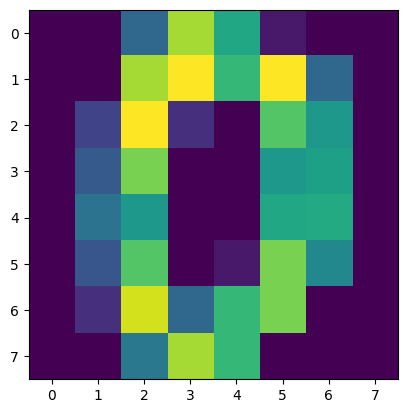

In [37]:
plt.imshow(X_test[0].reshape(8, 8))

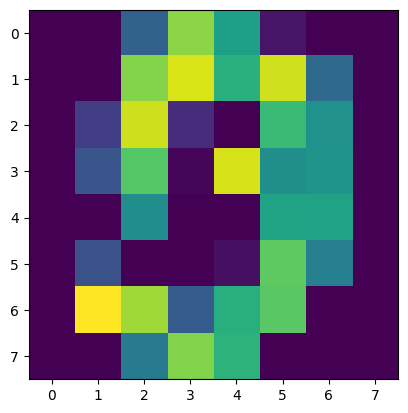

In [34]:
plt.imshow(X_cf[0].reshape(8, 8))